# EE4375: Second Lab Session: Finite Difference Method for the Poisson Equation on the Unit Interval

Extension examples of on how to use iterative solution methods for systems of linear equatiobns.

## Import Packages

In [1]:
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using Preconditioners
using IncompleteLU

using BenchmarkTools 

using Plots

## Section 1: One-Dimensional Mesh Generation

In [2]:
# struct to hold entire mesh
struct Mesh
  #..number of nodes of the mesh..   
  nnodes::Int64
  #..number of elements of the mesh..
  nelements::Int64 
  #..vector of x-coordinates of nodes of the mesh..
  Nodes::Vector{Float64}
end 

In [3]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    Nodes = Vector{Float64}(0:h:1)    
    mesh = Mesh(nnodes,nelements,Nodes)     
    return mesh;
end 

genMesh (generic function with 1 method)

In [4]:
# test function for type stability 
#@code_warntype genMesh(4);

In [5]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size 
@time genMesh(10);
@time genMesh(100);
@time genMesh(1000);
@time genMesh(10000);

  0.000023 seconds (1 allocation: 144 bytes)
  0.000003 seconds (1 allocation: 896 bytes)
  0.000004 seconds (1 allocation: 8.000 KiB)
  0.000013 seconds (2 allocations: 78.234 KiB)


## Section 2: Linear System Assembly

### Section 1.2: Assemble Stiffness Matrix

In [6]:
# generate global stiffness matrix 
function genStiffMat(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 

    #..construct the coefficient matrix with our the boundary conditions 
    e = ones(nnodes); #..note that ones(N+1,1) does *not* work here 
    A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
    A = (1/h2)*A;     
   
    return A; 
    
end

genStiffMat (generic function with 1 method)

In [7]:
#mesh = genMesh(10);
#code_warntype genStiffMat(mesh)

In [8]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time genStiffMat(mesh); # force function compilation 
mesh = genMesh(10);    @time genStiffMat(mesh); 
mesh = genMesh(100);   @time genStiffMat(mesh);
mesh = genMesh(1000);  @time genStiffMat(mesh); 
mesh = genMesh(10000); @time genStiffMat(mesh);

  0.000015 seconds (11 allocations: 1.359 KiB)
  0.000002 seconds (11 allocations: 1.359 KiB)
  0.000002 seconds (11 allocations: 7.969 KiB)
  0.000003 seconds (11 allocations: 71.719 KiB)
  0.000061 seconds (20 allocations: 703.828 KiB)


### Section 2.2: Assemble Right-Hand Side Vector

In [9]:
fsource(x) = x*(x-1)
fsource(x) = sin(π*x)

function genVector(mesh, sourceFct::F) where F 

    #..recover mesh nodes  
    nodes = mesh.Nodes
    
    #..set vector values using broadcasting (dot syntax)  
    f = sourceFct.(nodes)
   
    return f; 
end

genVector (generic function with 1 method)

In [10]:
#mesh = genMesh(10);
#@code_warntype genVector(mesh, fsource)

In [11]:
# observe again how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time f = genVector(mesh,fsource); # force function compilation
mesh = genMesh(10);    @time f = genVector(mesh,fsource);
mesh = genMesh(100);   @time f = genVector(mesh,fsource);
mesh = genMesh(1000);  @time f = genVector(mesh,fsource);
mesh = genMesh(10000); @time f = genVector(mesh,fsource);

  0.061642 seconds (144.19 k allocations: 7.559 MiB, 99.94% compilation time)
  0.000002 seconds (1 allocation: 144 bytes)
  0.000002 seconds (1 allocation: 896 bytes)
  0.000006 seconds (1 allocation: 8.000 KiB)
  0.000045 seconds (2 allocations: 78.234 KiB)


## Section 3: Solve Process 

In [12]:
#..set exact solution with homogeneous Dirichlet boundary conditions on both sides.. 
#..fourth derivative is zero - three point difference scheme is exact 
uexactFct1(x) = x*(x-1)
uexactFct2(x) = sin(π*x)

#..set exact solution with homogeneous Dirichlet left and homogeneous Neumann on the right..  
#..fourth derivative is zero - three point difference scheme is exact 
uexactFct3(x) = -0.5*x*x + x 
uexactFct4(x) = sin(π/2*x)

#..set exact solution with periodic boundary conditions: equal values and equal normal derivatives..    
uexactFct5(x) = sin(2*π*x) 

#..set source function: observe the minus sign: f(x) = - u''(x).. 
#..(we would like to set f(x) automatically given u(x))..  
fsourceFct1(x) = -2
fsourceFct2(x) = π*π*sin(π*x)

fsourceFct3(x) = 1. 
fsourceFct4(x) = π^2/4*sin(π/2*x)

fsourceFct5(x) = (4*π*π+1)*sin(2*π*x)

fsourceFct5 (generic function with 1 method)

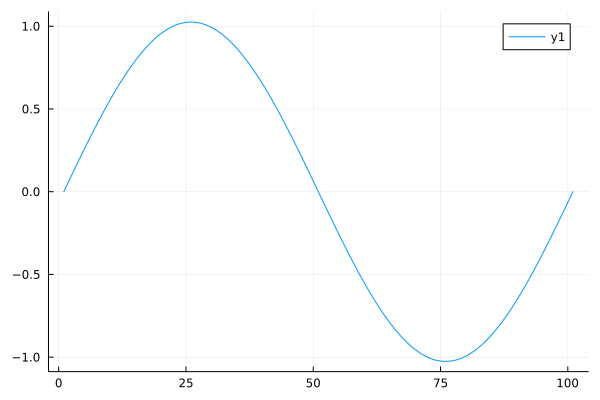

In [13]:
function genSolution(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 
    
    #..set homogeneous Dirichlet boundary conditions at both end points  
    if (true)
        A[1,1] = 1.; A[1,2] = 0.; f[1] = 0.;
        A[end,end] = 1.; A[end,end-1] = 0.; f[end] = 0.;
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-1")
        A[1,1] = 1.;        A[1,2] = 0.;         f[1] = 0.;
        A[end,end] = 1/h ;  A[end,end-1] = -1/h; f[end] = 0;        
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-2")
        A[1,1] = 1.;        A[1,2] = 0.;         f[1] = 0.;
        A[end,end] = 1/h ;  A[end,end-1] = -1/h; f[end] = h/2*f[end];        
    elseif (true)
        display(" Setting periodic boundary conditions ")
        A = sparse(A)
        A[1,end-1] = -1/h2; 
        A[end,2]   = -1/h2;
    else 
        error(" genSolution::Error::Boundary conditions not set")
    end 
    u = A\f 
    return u,A,f  
end

N = 100
#N = 4 
mesh = genMesh(N)
A = genStiffMat(mesh) # force compilation 
f = genVector(mesh,fsourceFct5) # force compilation
u, A, f = genSolution(mesh,A,f) # force compilation 
# @time u = genSolution(A,f)

plot(u)

In [14]:
# observe again how the number of memory allocations only depends midly on the mesh size
# observe how assembly is much faster than the solve 
mesh = genMesh(10);    @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,A,f = genSolution(mesh,A,f);
mesh = genMesh(100);   @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,A,f = genSolution(mesh,A,f);
mesh = genMesh(1000);  @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,A,f = genSolution(mesh,A,f);
mesh = genMesh(10000); @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,A,f = genSolution(mesh,A,f);

  0.000004 seconds (11 allocations: 1.359 KiB)
  0.000030 seconds (12 allocations: 1.047 KiB)
  0.000005 seconds (11 allocations: 7.969 KiB)
  0.000020 seconds (12 allocations: 5.469 KiB)
  0.000008 seconds (11 allocations: 71.719 KiB)
  0.000036 seconds (12 allocations: 48.031 KiB)
  0.000035 seconds (20 allocations: 703.828 KiB)
  0.000219 seconds (18 allocations: 469.438 KiB)


## Section 4: Solve Iteratively 

Converged after 5 iterations.

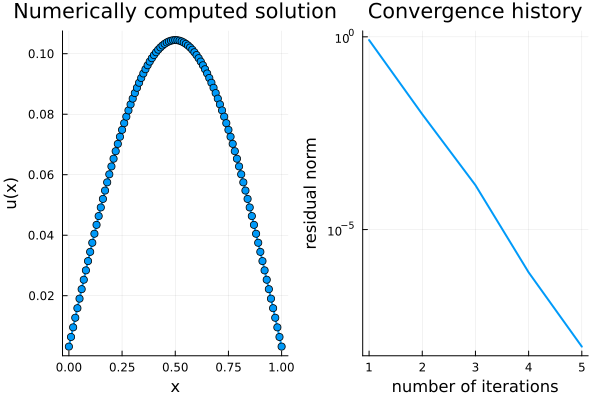

In [30]:
mesh = genMesh(100); A = genStiffMat(mesh); f = genVector(mesh,fsource);

A     = sparse(A)
#A     = A*A; # bi-harmonic 
prec  = ilu(A, τ = 0.1)
prec  = Diagonal(A);
prec  = AMGPreconditioner{RugeStuben}(A)
u, ch = cg(A, f, Pl=prec, maxiter=100000, log=true)

display(ch)

p1=plot(mesh.Nodes,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

p2=plot(ch[:resnorm], yaxis=:log,lw=2,legend=false)
xlabel!("number of iterations") 
ylabel!("residual norm")
title!("Convergence history")

plot(p1,p2)

We explain the succes (failure) of the Ruge-Stueben approach to AMG applied to Poisson (bi-harmonic) by showing that the inverse of the matrix is positive (is not positive) element-wise. The matrix is thus (fails to be) a so-called [M-matrix](https://en.wikipedia.org/wiki/M-matrix).  

In [31]:
# A     = A*A
B = inv(Matrix(A))
sum(B .>= 0)

10201

In [37]:
dump(prec)

AMGPreconditioner{RugeStuben, AlgebraicMultigrid.MultiLevel{AlgebraicMultigrid.Pinv{Float64}, AlgebraicMultigrid.GaussSeidel{AlgebraicMultigrid.SymmetricSweep}, AlgebraicMultigrid.GaussSeidel{AlgebraicMultigrid.SymmetricSweep}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}, SparseMatrixCSC{Float64, Int64}, AlgebraicMultigrid.MultiLevelWorkspace{Vector{Float64}, 1}}, AlgebraicMultigrid.V}
  ml: AlgebraicMultigrid.MultiLevel{AlgebraicMultigrid.Pinv{Float64}, AlgebraicMultigrid.GaussSeidel{AlgebraicMultigrid.SymmetricSweep}, AlgebraicMultigrid.GaussSeidel{AlgebraicMultigrid.SymmetricSweep}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}, SparseMatrixCSC{Float64, Int64}, AlgebraicMultigrid.MultiLevelWorkspace{Vector{Float64}, 1}}
    levels: Array{AlgebraicMultigrid.Level{SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}, SparseMatrixCSC{Float64, Int64}}}((4,))
      1: AlgebraicMultig

        2: Array{Float64}((50,)) [-5.964720167857161e-12, -9.230208361684197e-12, -1.249569655551123e-11, -9.910379019032777e-12, -7.325061482554324e-12, -8.647936679628367e-12, -9.97081187670241e-12, -1.2821611928745037e-11, -1.5672411980787666e-11, -1.2953138641044596e-11  …  4.8544906981796285e-11, 4.545666633088795e-11, 4.236842567997961e-11, 3.598355280483116e-11, 2.95986799296827e-11, 2.65755327071951e-11, 2.35523854847075e-11, 1.912876795400179e-11, 1.470515042329608e-11, 7.35257521164804e-12]
        3: Array{Float64}((25,)) [-2.0017407000815305e-12, -6.00522210024459e-12, -7.971837590045573e-12, -9.938453079846556e-12, -1.1066728060930953e-11, -1.2195003042015351e-11, -1.4363580707212496e-11, -1.653215837240964e-11, -1.9414931583986237e-11, -2.2297704795562832e-11  …  8.964140289288676e-12, 1.6726832301531086e-11, 2.4489524313773495e-11, 3.029213229431569e-11, 3.6094740274857885e-11, 3.5728585958952804e-11, 3.536243164304773e-11, 2.7861971541598886e-11, 2.0361511440150046e-11,

## Section 5: Sandbox 